In [178]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import pandasdmx as sdmx
from functools import reduce

# Data Fetching & Basic Manipulation

In [75]:
estat = sdmx.Request("ESTAT")

## Carbon Data

In [132]:
resp = estat.data(
	"ENV_AIR_GGE",
	key={
		"unit": "THS_T",
		"freq": "A",
		"src_crf": "TOTX4_MEMONIA",
		"airpol": "GHG"
	}
)
emission_df = resp.to_pandas(datetime={'dim': 'TIME_PERIOD'}).droplevel(level=['unit', 'freq', 'src_crf', 'airpol'], axis=1)
emission_df.reset_index(inplace=True)
emission_df["year"] = emission_df["TIME_PERIOD"].dt.year
emission_df.drop("TIME_PERIOD", inplace=True, axis=1)
emission_melted_df = pd.melt(emission_df, id_vars="year")

emission_melted_df.head()

2024-06-04 23:17:27,003 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message


,year,geo,value
0,1985,AT,NaN
1,1986,AT,NaN
2,1987,AT,NaN
3,1988,AT,NaN
4,1989,AT,NaN


In [ ]:
px.scatter(emission_melted_df, x="TIME_PERIOD", y="value", color="geo")

## Energy Data

In [153]:
def get_melted_energy_dfs(code: str) -> pd.DataFrame:
	"""
	A quick helper to get, parse, and melt the dataframes for a given energy `nrg_bal`.

	:param code: The `nrg_bal` code to fetch and melt
	:returns: A melted dataframe
	"""
	resp = estat.data(
		"NRG_D_HHQ",
		key={
			"siec": "TOTAL",
			"unit": "TJ",
			"nrg_bal": code,
			"freq": "A",
		}
	)
	household_energy_df = resp.to_pandas(datetime={'dim': 'TIME_PERIOD', 'freq': 'freq'}).droplevel(level=["siec", "unit", "nrg_bal"], axis=1)

	household_energy_df.reset_index(inplace=True)
	household_energy_df["year"] = household_energy_df["TIME_PERIOD"].dt.year
	household_energy_df.drop("TIME_PERIOD", inplace=True, axis=1)
	household_energy_melted_df = pd.melt(household_energy_df, id_vars="year")
	household_energy_melted_df.columns = ["year", "geo", code]
	return household_energy_melted_df

In [154]:
codes = ["FC_OTH_HH_E_SH", "FC_OTH_HH_E_SC", "FC_OTH_HH_E_WH", "FC_OTH_HH_E_CK"]
energy_dfs = [get_melted_energy_dfs(code) for code in codes]

2024-06-04 23:30:27,284 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message
/opt/homebrew/Caskroom/miniconda/base/envs/wafflers/lib/python3.11/functools.py:909: FutureWarning:

'A' is deprecated and will be removed in a future version, please use 'Y' instead.

2024-06-04 23:30:27,461 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message
/opt/homebrew/Caskroom/miniconda/base/envs/wafflers/lib/python3.11/functools.py:909: FutureWarning:

'A' is deprecated and will be removed in a future version, please use 'Y' instead.

2024-06-04 23:30:27,608 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message
/opt/homebrew/Caskroom/miniconda/base/envs/wafflers/lib/python3.11/functools.py:909: FutureWarning:

'A' is deprecated and will be removed in a future version, please use 'Y' instead.

2024-06-04 23:30:27,745 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for 

## Merge Datasets

In [199]:
to_merge_dfs = [emission_melted_df, *energy_dfs]
columns = ["year", "geo", "carbon", "energy_heating", "energy_cooling", "energy_water_heating", "energy_cooking"]
res_carbon_df = reduce(lambda l, r: pd.merge(l, r, left_on=["year", "geo"], right_on=["year", "geo"]), to_merge_dfs)
res_carbon_df.columns = columns
res_carbon_df.head()

,year,geo,carbon,energy_heating,energy_cooling,energy_water_heating,energy_cooking
0,2010,AT,86862.05,211567.042,21.359,40387.965,7011.298
1,2011,AT,84795.76,190731.846,25.123,41343.612,6891.695
2,2012,AT,81981.39,195419.278,34.215,41839.251,7026.774
3,2013,AT,82304.13,205494.885,31.035,41541.823,7353.560
4,2014,AT,78716.82,178513.717,27.645,42495.391,7152.047


In [200]:
res_carbon_df.iloc[:, 2:].corr()

,carbon,energy_heating,energy_cooling,energy_water_heating,energy_cooking
carbon,1.000000,0.950484,0.844733,0.947675,0.952764
energy_heating,0.950484,1.000000,0.920472,0.994126,0.992522
energy_cooling,0.844733,0.920472,1.000000,0.924791,0.929758
energy_water_heating,0.947675,0.994126,0.924791,1.000000,0.994235
energy_cooking,0.952764,0.992522,0.929758,0.994235,1.000000


## Standardize

In [202]:
res_carbon_df.drop(res_carbon_df[(res_carbon_df.geo == "EU27_2020") | (res_carbon_df.geo == "EU20")].index, inplace=True)

In [230]:
# TEST
res_carbon_df.drop("year", axis=1, inplace=True)

In [289]:
res_carbon_df.to_clipboard()

In [231]:
df_merged_s = pd.DataFrame()
for feat in res_carbon_df.columns:
	if feat == "geo": continue
	df_merged_s[f'{feat}'] = ((res_carbon_df[feat] - res_carbon_df[feat].mean()) / res_carbon_df[feat].std())
df_merged_s["geo"] = res_carbon_df["geo"]
# df_merged_s["year"] = res_carbon_df["year"]
df_merged_s.head()

,carbon,energy_heating,energy_cooling,energy_water_heating,energy_cooking,geo
0,-0.270778,0.005791,-0.467261,-0.075604,-0.354672,AT
1,-0.281369,-0.049254,-0.465859,-0.063681,-0.358060,AT
2,-0.295793,-0.036870,-0.462471,-0.057498,-0.354234,AT
3,-0.294139,-0.010251,-0.463656,-0.061208,-0.344978,AT
4,-0.312524,-0.081533,-0.464919,-0.049312,-0.350685,AT


## Dummies

In [232]:
df_dummies = pd.get_dummies(df_merged_s, dtype=int)
print(df_dummies.shape)
df_dummies.head()

(364, 33)


,carbon,energy_heating,energy_cooling,energy_water_heating,energy_cooking,geo_AT,geo_BE,geo_BG,geo_CY,geo_CZ,...,geo_LV,geo_MT,geo_NL,geo_NO,geo_PL,geo_PT,geo_RO,geo_SE,geo_SI,geo_SK
0,-0.270778,0.005791,-0.467261,-0.075604,-0.354672,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.281369,-0.049254,-0.465859,-0.063681,-0.358060,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-0.295793,-0.036870,-0.462471,-0.057498,-0.354234,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-0.294139,-0.010251,-0.463656,-0.061208,-0.344978,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-0.312524,-0.081533,-0.464919,-0.049312,-0.350685,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [288]:
df_dummies = df_dummies.fillna(0)

## Linear Regression

In [234]:
X = np.pad(df_dummies.iloc[:, 1:].to_numpy(), ((0,0), (1,0)), mode="constant", constant_values=1)
y = np.array(df_dummies["carbon"])
X[0:2,]

array([[ 1.        ,  0.00579135, -0.46726144, -0.07560401, -0.35467208,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 1.        , -0.04925367, -0.46585892, -0.0636813 , -0.35805979,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ]])

In [235]:
m = np.matmul(np.linalg.inv(np.matmul(X.T, X)), np.matmul(X.T, y))
np.set_printoptions(suppress=True) #this just prevents python from printing it out in inconvenient scientific notation
m

array([ 0.37222448,  0.5223011 , -0.05161035, -0.61810575,  0.12303269,
       -0.36377837, -0.8083168 , -0.98725832, -1.43894754, -0.72166141,
        3.67563685, -0.82824913, -1.18894754, -1.10229215,  1.04523083,
       -0.90493835,  0.51144635, -1.31676292, -0.98725832, -0.88219065,
        0.85654786, -0.72729215, -1.32672908, -1.15060293, -1.47729215,
       -0.42639073, -0.9560645 ,  0.75277552, -0.86484897, -0.68179675,
       -0.78990451, -1.21169524, -1.04964596])

In [236]:
# get the residuals
res = y - np.matmul(X, m)
print(res[0:5])
round(sum(res), 1)

[-0.30945998 -0.28344126 -0.30080717 -0.31654979 -0.28971399]


64.1

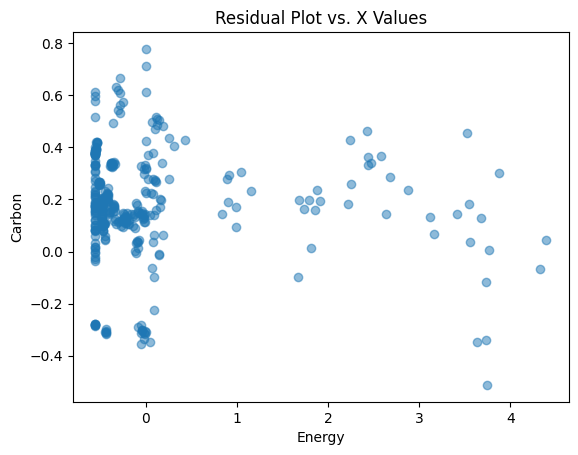

In [237]:
# x values versus residuals
plt.scatter(X[:, 1:2], res, alpha=0.5)
plt.xlabel("Energy")
plt.ylabel("Carbon")
plt.title("Residual Plot vs. X Values")
plt.show()

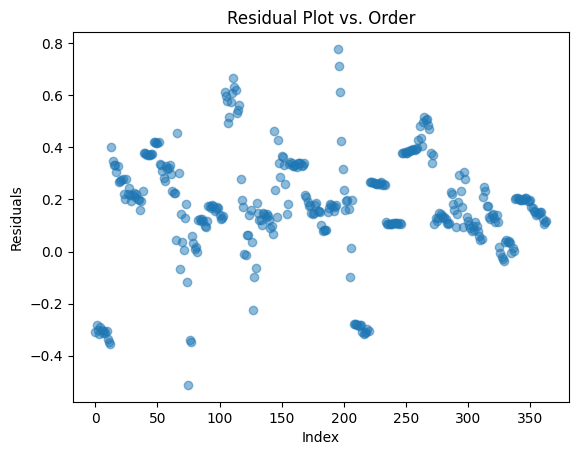

In [238]:
# residuals versus order
plt.scatter(range(len(X[:,1:2])), res, alpha=0.5)
plt.xlabel("Index")
plt.ylabel("Residuals")
plt.title("Residual Plot vs. Order")
plt.show()

In [244]:
px.scatter(df_merged_s, y="carbon", x="energy_heating", color="geo")

In [213]:
from sklearn.metrics import r2_score

In [246]:
np_remove = lambda a, i: np.concatenate([a[:i,], a[i + 1:,]])
lin_reg = lambda X, Y: np.matmul(np.linalg.inv(np.matmul(X.T, X)), np.matmul(X.T, Y))

def loo_cv_pred(X, Y):
	"""
	Predict Y values using leave one out cross validation

	:param X: The X features array (including bias column)
	:param Y: The true Y values
	:return: An array of the predicted Y-Vals
	"""
	y_pred = []
	for i in range(len(X)):
		holdout_X = X[i]
		
		loo_X = np_remove(X, i)
		loo_y = np_remove(Y, i)
		loo_b = lin_reg(loo_X, loo_y)

		y_hat = np.matmul(holdout_X, loo_b)
		y_pred.append(y_hat)
	
	return y_pred

In [247]:
preds = loo_cv_pred(X, y)

In [248]:
r2_score(y, preds)

0.6267042262195361

# Experiment: Model per country

In [279]:
df_be = df_merged_s.loc[df_merged_s["geo"] == "FR"]
df_be

,carbon,energy_heating,energy_cooling,energy_water_heating,energy_cooking,geo
156,1.962098,3.156258,0.049519,1.422028,1.976399,FR
157,1.838539,2.430414,1.000927,1.636463,2.337869,FR
158,1.844259,2.873586,1.000302,1.614002,2.229544,FR
159,1.841121,3.118138,1.073088,1.635543,2.142887,FR
160,1.675800,2.240820,1.143476,1.616531,2.043686,FR
161,1.699596,2.474152,1.236836,1.629732,2.059423,FR
162,1.708232,2.677761,1.628912,1.660820,2.041405,FR
163,1.722893,2.583788,1.621449,1.696977,2.089008,FR
164,1.628270,2.434724,1.853032,1.704964,2.100902,FR
165,1.581249,2.432933,2.190273,1.693026,2.052831,FR


In [280]:
X_be = np.pad(df_be.iloc[:, 1:5].to_numpy(), ((0,0), (1,0)), mode="constant", constant_values=1)
y_be = np.array(df_be["carbon"])
X_be[0:2,]

array([[1.        , 3.15625764, 0.04951903, 1.4220275 , 1.97639861],
       [1.        , 2.43041402, 1.00092731, 1.63646348, 2.33786898]])

In [281]:
beta_be = lin_reg(X_be, y_be)

In [282]:
res_be = y_be - np.matmul(X_be, beta_be)
print(res_be[0:5])
round(sum(res_be), 1)

[-0.05395949  0.03933248  0.00048339 -0.0018462  -0.02048255]


0.0

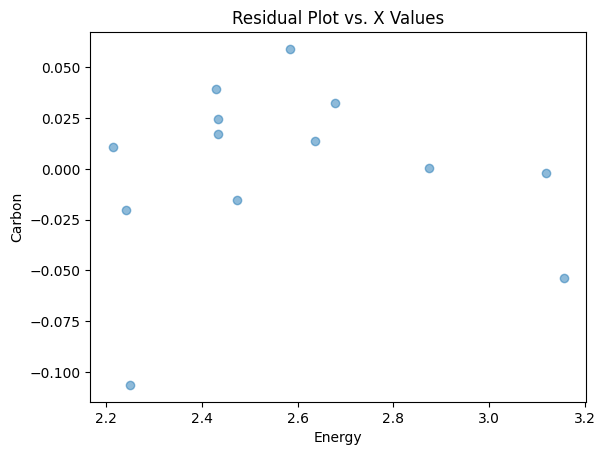

In [283]:
# x values versus residuals
plt.scatter(X_be[:, 1:2], res_be, alpha=0.5)
plt.xlabel("Energy")
plt.ylabel("Carbon")
plt.title("Residual Plot vs. X Values")
plt.show()

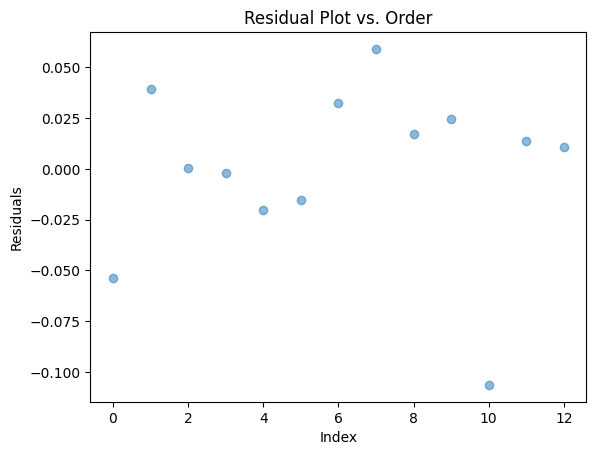

In [284]:
# residuals versus order
plt.scatter(range(len(X_be[:,1:2])), res_be, alpha=0.5)
plt.xlabel("Index")
plt.ylabel("Residuals")
plt.title("Residual Plot vs. Order")
plt.show()

In [285]:
px.scatter(df_be, x="energy_heating", y="carbon")

In [286]:
preds_be = loo_cv_pred(X_be, y_be)

In [287]:
r2_score(y_be, preds_be)

0.8016784112747927